#### PCA Pattern Find on Spontaneous Data

PCA is one of the most classical methods. for pattern find.    
PCA will return patterns that explained most VAR. And For each pattern, it will also return a weight curve, indicating repeatance of pattern.    
Parts are as follows:    
1. Bin and 1D vectorization for PCA analysis
2. Spacial PCA
3. Temporal PCA
4. PCA based trajectory

___
- #### Part 1, bin and vectorization.    
After this procedure, a feature x sample matrix will be return. 

In [1]:
# import 
import Common_Functions as cf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import pandas as pd
from Brain_Atlas.Atlas_Mask import Mask_Generator
from Atlas_Corr_Tools import *
from scipy.stats import pearsonr
from Signal_Functions.Pattern_Tools import Do_PCA

wp = r'D:\_DataTemp\OIS\Wild_Type\Preprocessed'
MG = Mask_Generator(bin=4)


In [2]:
# load data

series = np.load(cf.join(wp,'z_series.npy'))
# join chamber mask with brain area mask, getting only mask with values.
mask = cv2.imread(cf.join(wp,'Chamber_mask.png'),0)>0
joint_mask = (series.std(0)>0)*mask
# mask and clip input graph.
# NOTE this part is important for getting correct results.
series = np.clip(series,-3,3)*joint_mask

- Bin full frame as 5*5, each pix indicate 200um.    
This resolution is similar to reference: https://doi.org/10.1038/s41467-023-44363-z


100%|██████████| 66/66 [00:17<00:00,  3.74it/s]


(18025, 66, 57)


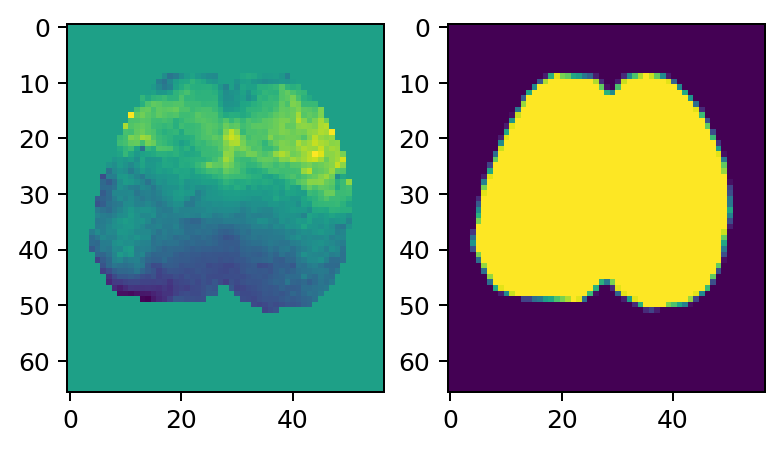

In [3]:

series_reshape = series.reshape(len(series),66,5,57,5)
# we need mask in boulder adjusted, so I cannot avr graph directly.
series_bin = np.zeros(shape = (18025,66,57),dtype='f8')
mask_reshape = (series.std(0)>0).reshape(66,5,57,5)
for i in tqdm(range(66)):
    for j in range(57):
        c_block = series_reshape[:,i,:,j,:].sum(-1).sum(-1)
        c_masknum = mask_reshape[i,:,j,:].sum()
        if c_masknum>0: # have a value.
            series_bin[:,i,j] = c_block/c_masknum

print(series_bin.shape)

# as you can see, the mask have different values in boulder.
fig,ax = plt.subplots(ncols=2,nrows=1,figsize = (5,3),dpi = 180)
ax[0].imshow(series_bin[5500,:,:])
ax[1].imshow(mask_reshape.mean(-1).mean(-2))

# delete var to save memory.
del series,series_reshape

This resolution seems low, but it's OK for global network recognition. 
- Next we will show how to flatten ONLY pixel with avaliable value.

In [4]:
# flatten only mask with value.
# and keep only symetry matrix.

on_mask = series_bin.std(0)>0
on_mask *= on_mask[:,::-1]
on_response = series_bin[:,on_mask==True].T

print(f'Mask in shape {on_mask.shape}, total ON pix :{on_mask.sum()}')
print(f'Graph have already been vectorized: {on_response.shape}')

cf.Save_Variable(wp,'Response_1d',(on_response,on_mask))

Mask in shape (66, 57), total ON pix :1574
Graph have already been vectorized: (1574, 18025)


True

Codes below show how to recover a 1D vector to its original location.

<Axes: >

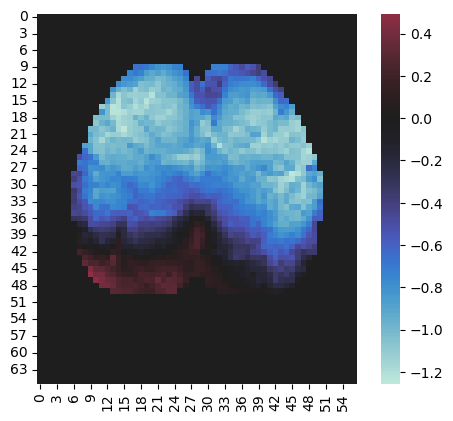

In [5]:

on_response,on_mask = cf.Load_Variable(wp,'Response_1d.pkl')

# recover any vector to graph.
target = on_response[:,250] # any single frame
recover = copy.deepcopy(on_mask).astype('f8')
recover[recover==True] = target

sns.heatmap(recover,center=0,square=True)



___
- #### Spatial PCA
We have a packed function for PCA analysis, 2 methods of PCA are possible.    
**NOTE: Sometimes PCA will stuck... I might solved the problem but I'm not sure.**    

For spatial PCA, each PC is a set of pixel (a functional components), weights are time series.


- Spatial PCA first.    
Spatial PCA use pix as feature, each sample is a timepoint. After transformation, each PC is a graph.

In [6]:
# Use only 1 line for PCA analysis.
PC_Comp_raw,coords_raw,model_raw = Do_PCA(on_response,feature='Area',pcnum=75)

print(f'PC_Comp are in shape N_Comp*N_feature:{PC_Comp_raw.shape}')
print(f'Coords_raw are in shape N_Sample*N_Comp:{coords_raw.shape}')


PC_Comp are in shape N_Comp*N_feature:(75, 1574)
Coords_raw are in shape N_Sample*N_Comp:(18025, 75)


model_raw is the raw model, you can use it to show explained variance of each PC.    
You can also input a graph to transfer it into PC space.    
For more detail, check official website:https://scikit-learn.org/1.6/modules/generated/sklearn.decomposition.PCA.html

First PC explained VAR 87.98%
Top 20 PC explained var: 99.60%


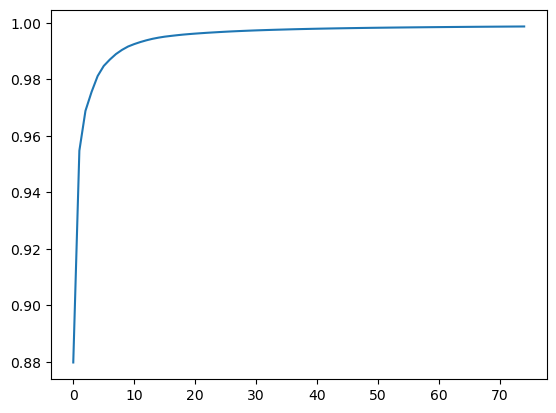

In [7]:
# plot explained var ratio by PC number
plt.plot(np.cumsum(model_raw.explained_variance_ratio_))

print(f'First PC explained VAR {model_raw.explained_variance_ratio_[0]*100:.2f}%')
print(f'Top 20 PC explained var: {np.sum(model_raw.explained_variance_ratio_[:20]*100):.2f}%')


Use coords_raw, we can get each PC's weight curve, indicating the repeatance strength.    
As we can see below, networks decay very fast, only first several network matters.

<Axes: >

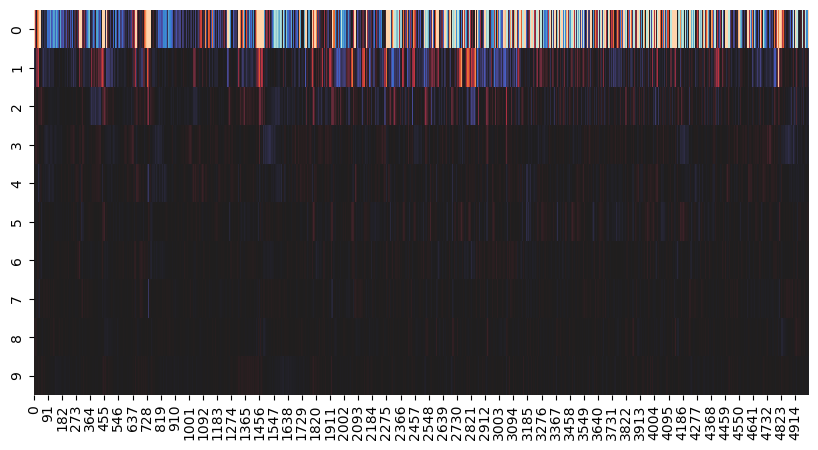

In [8]:
fig,ax = plt.subplots(figsize = (10,5))
sns.heatmap(coords_raw[5000:10000,:10].T,center = 0,vmax = 50,vmin = -50,ax = ax,cbar=False)

PC1 is similar to global signal, and other maps similar to that in reference.    

<Axes: >

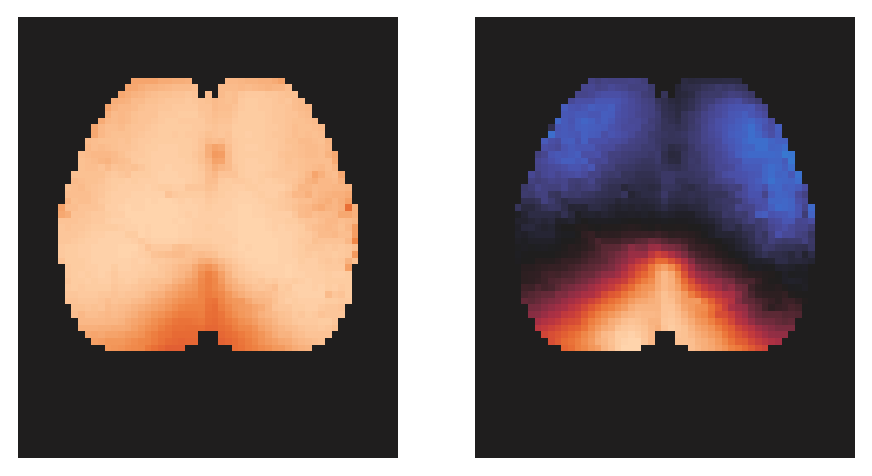

In [9]:
def Recover_Map(vec,mask):
    recover = copy.deepcopy(on_mask).astype('f8')
    recover[recover==True] = vec
    return recover

fig,ax = plt.subplots(ncols=2,nrows=1,figsize = (6,4),dpi = 180)


sns.heatmap(Recover_Map(PC_Comp_raw[0,:],on_mask),center = 0,cbar=False,ax = ax[0],xticklabels=False,yticklabels=False,square=True)
sns.heatmap(Recover_Map(PC_Comp_raw[1,:],on_mask),center = 0,cbar=False,ax = ax[1],xticklabels=False,yticklabels=False,square=True)
# sns.heatmap(recover,center=0,square=True)

In [10]:
# save PC's pattern.
savepath = cf.join(wp,'PC_Spatial')
cf.mkdir(savepath)
for i in tqdm(range(len(PC_Comp_raw))):
    c_map = Recover_Map(PC_Comp_raw[i,:],on_mask)

    plt.clf()
    # plt.cla()
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize = (5,5),dpi = 240)
    sns.heatmap(c_map,xticklabels=False,yticklabels=False,square=True,ax = ax,center=0)
    fig.savefig(cf.join(savepath,f'{10000+i}.png'))
    plt.close(fig)

Folder D:\_DataTemp\OIS\Wild_Type\Preprocessed\PC_Spatial already exists!


100%|██████████| 75/75 [00:05<00:00, 14.10it/s]


<Figure size 640x480 with 0 Axes>

___
#### Part 3, Temporal PCA
Similart to spatial PCA, for temporal PCA, each PC is a combination of time (a temporal combination), weights are pix's contribution (actuall a functional map.)    

**NOTE** that the shape of PC and coords are DIFFERENT from that of Area PCA.

PC_Comp are in shape N_Comp*N_feature:(75, 18025)
Coords_raw are in shape N_Sample*N_Comp:(1574, 75)
First PC explained VAR 61.54%
Top 20 PC explained var: 96.91%


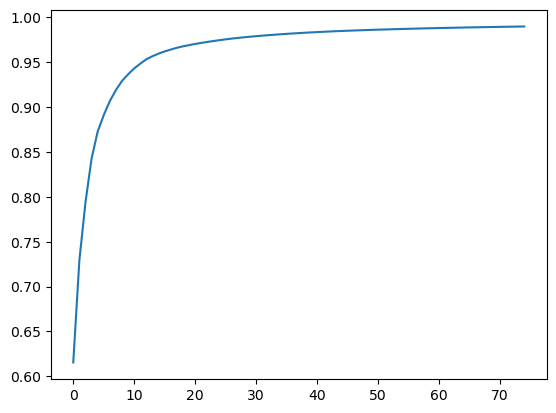

In [11]:
PC_Comp_raw_t,coords_raw_t,model_raw_t = Do_PCA(on_response,feature='Time',pcnum=75)

print(f'PC_Comp are in shape N_Comp*N_feature:{PC_Comp_raw_t.shape}')
print(f'Coords_raw are in shape N_Sample*N_Comp:{coords_raw_t.shape}')


# plot explained var ratio by PC number
# Temporal PCA have slower VAR decay.
plt.plot(np.cumsum(model_raw_t.explained_variance_ratio_))
print(f'First PC explained VAR {model_raw_t.explained_variance_ratio_[0]*100:.2f}%')
print(f'Top 20 PC explained var: {np.sum(model_raw_t.explained_variance_ratio_[:20]*100):.2f}%')

Note that for temporal PCA, the PC indicate a set of time that having similar pattern.    
So global signal will not be shown.

<Axes: >

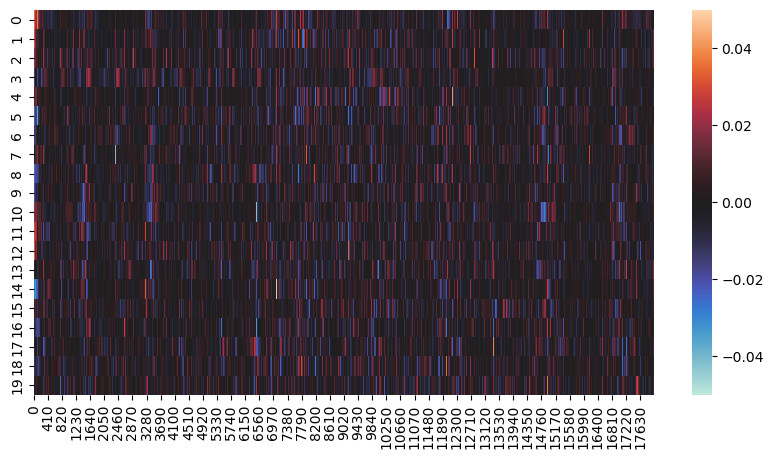

In [12]:
fig,ax = plt.subplots(figsize = (10,5))
sns.heatmap(PC_Comp_raw_t[:20,:],center = 0,ax = ax,vmax = 0.05,vmin = -0.05)

Text(0.5, 1.0, 'PC2 Coords')

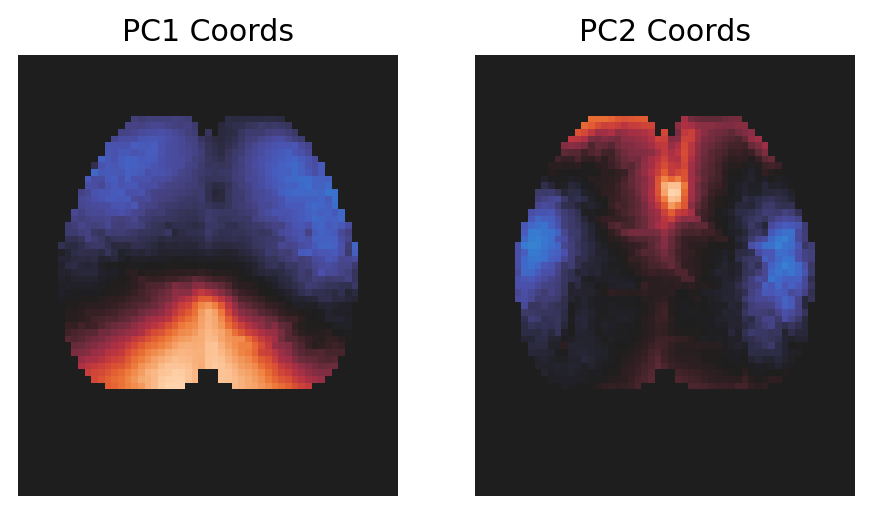

In [13]:
def Recover_Map(vec,mask):
    recover = copy.deepcopy(on_mask).astype('f8')
    recover[recover==True] = vec
    return recover

fig,ax = plt.subplots(ncols=2,nrows=1,figsize = (6,4),dpi = 180)


sns.heatmap(Recover_Map(coords_raw_t[:,0],on_mask),center = 0,cbar=False,ax = ax[0],xticklabels=False,yticklabels=False,square=True)
sns.heatmap(Recover_Map(coords_raw_t[:,1],on_mask),center = 0,cbar=False,ax = ax[1],xticklabels=False,yticklabels=False,square=True)
ax[0].set_title('PC1 Coords')
ax[1].set_title('PC2 Coords')


In [14]:
# save PC's pattern.
savepath = cf.join(wp,'PC_Temporal')
cf.mkdir(savepath)
for i in tqdm(range(len(PC_Comp_raw_t))):
    c_map = Recover_Map(coords_raw_t[:,i],on_mask)

    plt.clf()
    # plt.cla()
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize = (5,5),dpi = 240)
    sns.heatmap(c_map,xticklabels=False,yticklabels=False,square=True,ax = ax,center=0)
    fig.savefig(cf.join(savepath,f'{10000+i}.png'))
    plt.close(fig)

Folder D:\_DataTemp\OIS\Wild_Type\Preprocessed\PC_Temporal already exists!


100%|██████████| 75/75 [00:05<00:00, 13.19it/s]


<Figure size 640x480 with 0 Axes>

- Another advantage of temporal PCA is that we can visualize each pix's PC weight.    
Visualize it in RGB will return a PC weight map.

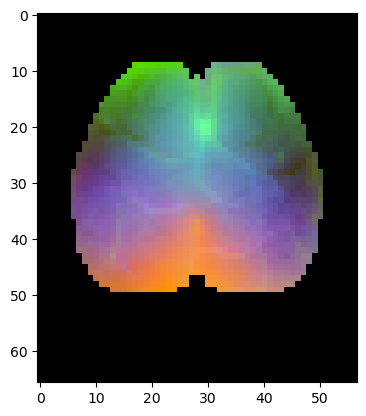

In [83]:
colors = (coords_raw_t[:,:3]/abs(coords_raw_t[:,:3]).max(0)+1)/2
# colors = coords_raw_t[:,:3]
img = np.array([on_mask,on_mask,on_mask]).transpose(1,2,0).astype('f8')
img[on_mask==True,:] = colors
plt.imshow((img*255).astype('u1'))
# plt.imshow((img))

____
#### Part 4, Time Trajectory of brain state.    
Using PC as coordinate, we can describe the time trajectory of current neuro-state.    
This method can be used on all kinds of dimension reduction algorithm.

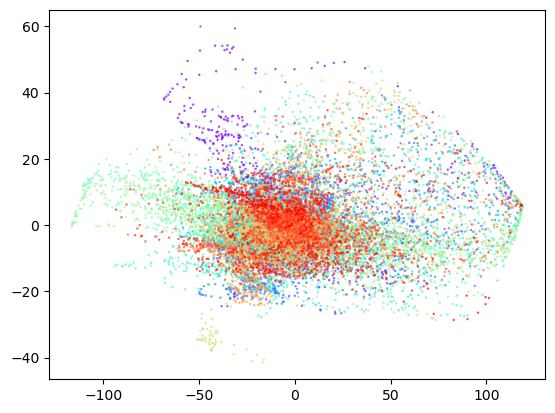

In [161]:
# plt.plot(coords_raw[500:1000,1],coords_raw[500:1000,2])
trace = coords_raw[:,[0,1]]
# trace = PC_Comp_raw_t[[2,3],:]
# trace = trace.reshape((-1,5,2))[:,1,:]
# plt.plot(PC_Comp_raw_t[0,7000:7200],PC_Comp_raw_t[1,7000:7200])
# plt.plot(trace[0,:],trace[1,:])
# plt.plot(trace[:,0],trace[:,1])
# plt.scatter(x = trace[0,:],y = trace[1,:],c=range(len(trace[0,:])),s = 3,cmap='rainbow',alpha=0.7,edgecolors='none')
plt.scatter(x = trace[:,0],y = trace[:,1],c=range(len(trace)),s = 3,cmap='rainbow',alpha=0.7,edgecolors='none')

as you can see, there are different distribution of points in different times! This can be very Instructive.    
Codes below will return you gif of spatial and temporal PCA.

*Actually PCA's trace may not have the best effect, we will introduce UMAP and HMM method in the future.*

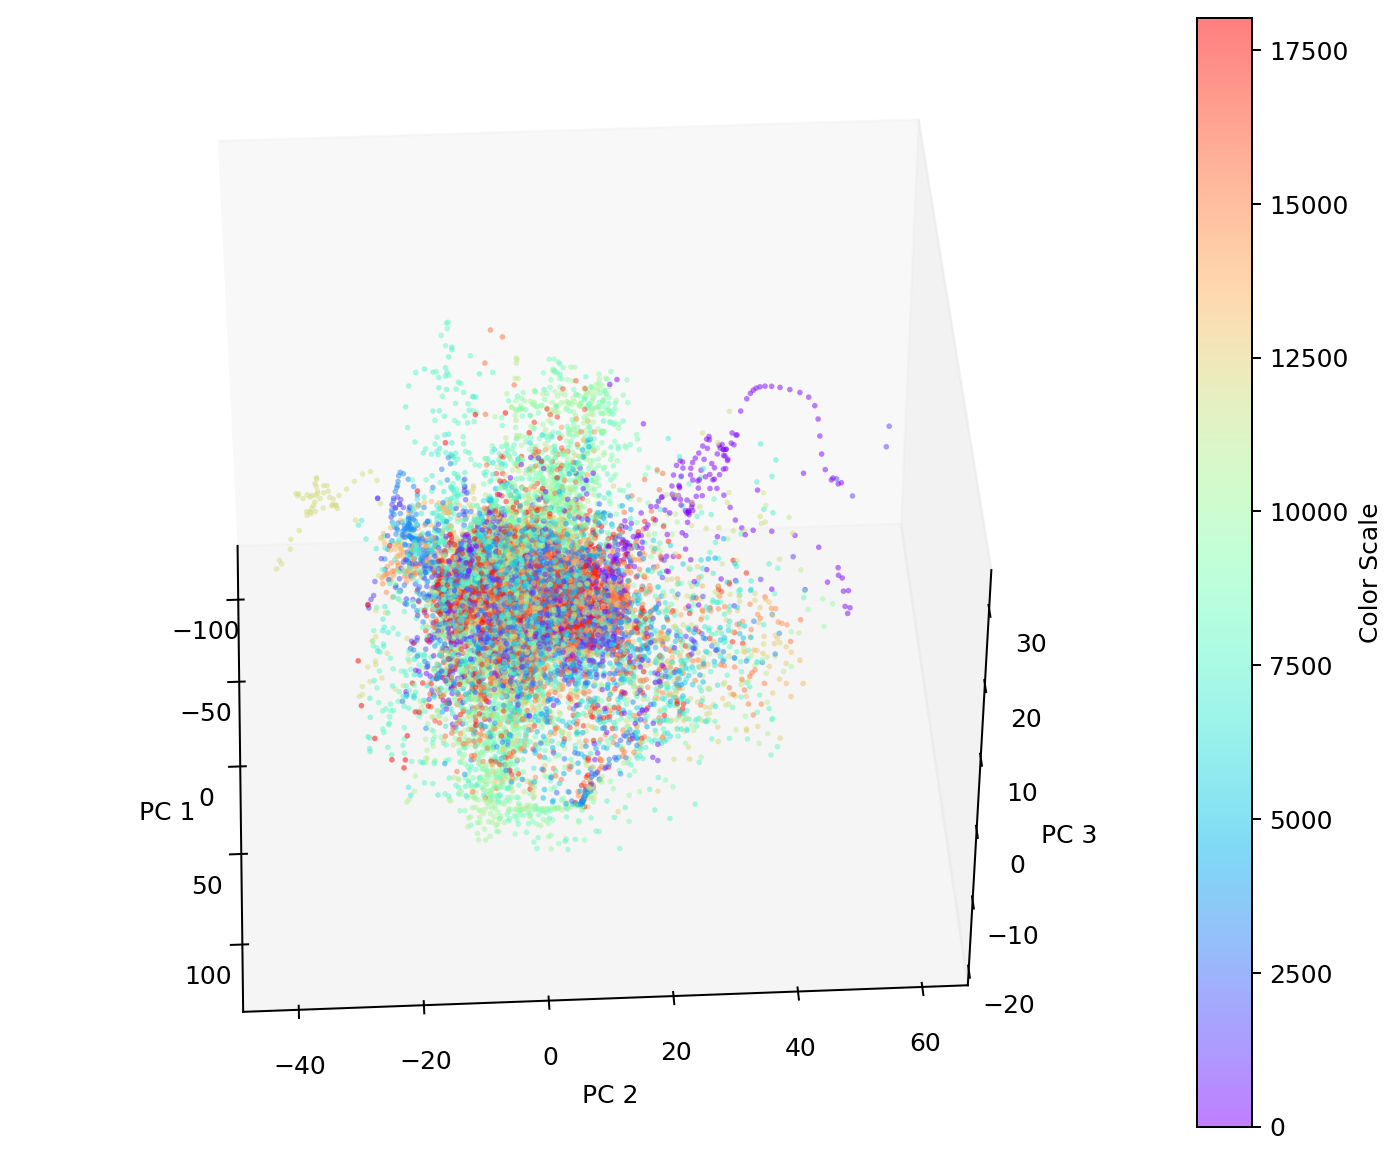

In [178]:
from matplotlib.animation import FuncAnimation
from PIL import Image  # For GIF processing

u = coords_raw[:,[0,1,2]] # for spatial PCA
# u = PC_Comp_raw_t[[0,1,2],:]  # for temporal PCA


fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': '3d'},figsize = (10,8),dpi = 180)
# ax.view_init(elev=45, azim=200)
ax.grid(False)

scatter = ax.scatter(u[:,0],u[:,1],u[:,2],c=range(len(u)), cmap='rainbow', alpha=0.5,edgecolors='none',s=5) # for spatial PCA
# scatter = ax.scatter(u[0,:],u[1,:],u[2,:],c=range(len(u[0])), cmap='rainbow', alpha=0.5,edgecolors='none',s=5) # for temporal PCA
# scatter = ax.plot(u[:,0],u[:,1],u[:,2])

plt.colorbar(scatter, label='Color Scale')
# ax.legend(['Data Points'])
# ax.set_xlim(-100,100)
# ax.set_ylim(-40,40)
# ax.set_zlim()
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')



## Codes below will make gif
n_frames = 120  
azim_step = 3 
elevation = 40  # Fixed elevation angle
def update(frame):
    """Update function for each animation frame"""
    ax.view_init(elev=elevation, azim=frame*azim_step)
    return scatter,

ani = FuncAnimation(fig, 
                   update, 
                   frames=n_frames,
                   blit=True,
                   interval=50)

# Save as GIF
ani.save(cf.join(wp,'Spatial_PCA_Trace.gif'), 
        writer='pillow', 
        fps=12,  # Adjust for rotation speed
        dpi=180)